# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Este tutorial está basado en el tutorial oficial de los autores de Tensorflow. En él se demuestra cómo generar imágenes de dígitos manuscrtos utilizando una [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). El código se ha escrito utilizando la [API secuencial de Keras](https://www.tensorflow.org/guide/keras) con un bucle de entrenamiento `tf.GradientTape`.

## Qué son las GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) son una de las ideas más interesantes de este campo a día de hoy. Se entrenan dos modelos de forma simultanea convirtiéndolos en adversarios. Un *generador* (el artista) aprende a crear imágenes que parezcan reales, mientras un *discriminador* (el crítico de arte) aprende a distinguir imágenes reales de copias.

![Diagrama del generador y el discriminador](https://drive.google.com/uc?id=1FtOAjDNCr4sI5lucz6adIqJEZrQL6d5Q)

Durante el entrenamiento, el *generador* va mejorando de forma progresiva a crear imágenes que parecen reales, mientras que el *discriminador* va haciéndose mejor en distinguirlas. El proceso alcanza un equilibrio cuando el *discriminador* ya no puede distinguir las imágenes.

![Segundo diagrama del generador y el discriminador](https://drive.google.com/uc?id=1zthTIpJdyWmp3sp75YyhHJQ0SHY1QPFL)

Este notebook demuestra este proceso en el dataset MNIST. La siguiente animación muestra una serie de imágenes producidas por el *generador* tras entrenar 50 épocas. Las imágenes comienzan siendo ruido aleatorio, y a medida que avanza el entrenamiento van pareciendo cada vez más números manuscritos.

![Muestra del output](https://tensorflow.org/images/gan/dcgan.gif)

Para aprender más acerca de las redes, podemos echar un vistazo al curso del MIT [Intro to Deep Learning](http://introtodeeplearning.com/).

### Importamos TensorFlow y otras librerías

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
# Generación de GIFs
!pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Carga y prepara el dataset

Vas a utilizar el dataset MNIST para entrenar el generador y el discriminador. El generador, por tanto, aprenderá a generar dígitos manuscritos del mismo tipo que los presentes en MNIST.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalizamos las imágenes al rango [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Dividimos los datos en batches y los aleatorizamos
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creación de modelos

Tanto el generador como el discriminador van a ser definidos usando la [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### El generador

El generador utiliza capas `tf.keras.layers.Conv2DTranspose` (upsampling) para producir una imágen a partir de una semilla (ruido aleatorio). Comienza con una capa `Dense`que toma la semilla como entrada, después la escala (upsample) varias veces hasta alcanzar el tamaño de imágen deseado de 28x28x1. Utilizaremos capas de activación `tf.keras.layers.LeakyReLU`, excepto para la capa de salida, que usará tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Utiliza el generador (aún sin entrenar) para crear una imágen.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

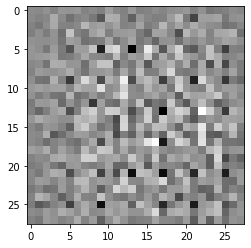

In [ ]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### El discriminador

El discriminador es un clasificador de imágenes basado en CNNs.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Utiliza el discriminador (aún sin entrenar) para clasificar las imágenes como reales o fake. El modelo se entrenará para sacar valores positivos con imágenes reales y valores negativos con imágenes fake.

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

## Definición de la función de coste y el optimizador

Definimos la función de coste y los optimizadores para ambos modelos.


In [ ]:
# Este método devuelve una función helper para calcular cross entropy loss. 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Función de coste del Discriminador

Este método cuantifica cuán bien el dicriminador es capaz de distinguir entre imágenes reales y falsas. Va a comparar las predicciones de imágenes reales con un array de 1s, y las predicciones de imágenes falsas con un array de 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Coste del generador

La función de coste del generador cuantifica cuán bien es capaz de engañar al discriminador. De forma intuitiva, si el generador funciona bien, el descriminador se equivocará. Aquí vamos a comparar las decisiones del discriminador en las imágenes falsas con un array de 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

El discriminador y el generador tendrán optimizadores separados ya que vamos a entrenar las redes de forma separada.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Guardar checkpoints

Este notebook también demuestra cómo guardar y recuperar modelos, lo que puede ser muy útil en caso de que el entrenamiento se pause o queramos utilizarlo a posteriori.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Definiendo el bucle de entrenamiento

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Vamos a reutilizar esta semilla para visualizar mejor el progreso en el GIF.
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed

El bucle de entrenamiento comienza con el generador recibiendo una semilla aleatoria como entrada. Esta semilla se usa para producir una imagen. El discriminador se utiliza después para clasificar imágenes reales (del dataset) e imágenes falsas (producidas por el generador). El coste se calcula para cada una de las redes por separado y se actualizan los pesos mediante descenso por gradiente.

In [ ]:
# Aquí utilizamos `tf.function`
# Esto hace que la función se "compile".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Producimos imágenes para el GIF sobre la marcha
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Guardamos el modelo cada 15 épocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generación tras cada época
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generación y guardado de imágenes**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Nótese que `training` está marcado como falso.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Entrenamos el modelo

Llamamos a la función `train()` definida anteriormente para enrtenar el generador y el discriminador de forma simultanea. Entrenar GANs es complejo, es importante que el generador y el discriminador no aventajen mucho al adversario (ambos deberían entrenar a un ritmo parecido).

Al principio del entrenamiento, las imágenes generadas van a parecer ruido aleatorio. A medida que el entrenamiento progrese, los dígitos generados irán pareciendo cada vez más reales. Tras unas 50 épocas, ya son como dígitos de MNIST.

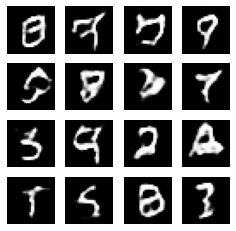

In [ ]:
train(train_dataset, EPOCHS)

Reestablecemos el último checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Creamos el GIF


In [ ]:
# Muestra de una imágen según el número de época
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Usamos `imageio` para crear un gif animado con estas imágenes.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

Si estás trabajando en Colab, puedes descargar la animación con el siguiente código.

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)